In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics

In [3]:
PATH = "../data/bulldozers/"

In [4]:
set_plot_sizes(12,14,16)

In [5]:
df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [ ]:
df_raw.Enclosure.cat.codes

In [6]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [7]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [ ]:
df_raw

In [ ]:
# set_rf_samples(50000)

# As of sklearn v0.22, max_samples has been added as a hyperparameter for RandomForestRegressor 
# that doesn't conflict with oob_score

In [8]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, max_samples=50000, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 8.48 s
[0.20583436159124924, 0.2481167892672459, 0.9114536671426431, 0.8900588490597687, 0.8943976262650957]


In [9]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 1.05 s


(9.332705718407503, 0.3382733526851133)

In [ ]:
??ProcessPoolExecutor

In [12]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

(9.332705718407503, 0.3382733526851133)

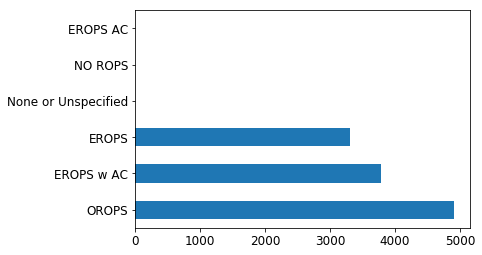

In [13]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [ ]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

In [ ]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

In [ ]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

In [ ]:
raw_valid.ProductSize.value_counts().plot.barh();

In [ ]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

In [ ]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

In [ ]:
fi = rf_feat_importance(m, df_trn); fi[:10]

In [ ]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [ ]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [ ]:
plot_fi(fi[:30]);

In [ ]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

In [ ]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [ ]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);